# Imports

In [ ]:
import os
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# PyTorch imports
import torch
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms_v2

from torch import optim
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Data Loading

In [42]:
# Charger le fichier Pickle
train_data_path = Path('data/train_data.pkl')
with open(train_data_path, 'rb') as f:
    data = pickle.load(f)

images = data['images']
labels = data['labels']

In [ ]:
# Check the shapes of images and labels
images.shape, labels.shape

((1080, 28, 28, 3), (1080, 1))

In [ ]:
# Display first image and label
image_ex = images[0]
label_ex = labels[0]
image_ex.shape, label_ex.shape

((28, 28, 3), (1,))

Notre CNN nécessitera le nombre de canaux de nos images (grayscale ou RGB) et la taille de notre image :

In [ ]:
nb_of_channels = image_ex.shape[2]
dimension_of_image = image_ex.shape[0]
nb_of_channels, dimension_of_image

(3, 28)

Pour connaître le nombre de classes que l'on peut prédire, on fait :

In [46]:
nb_of_classes = len(np.unique(labels.flatten()))
nb_of_classes

5

# Architecture Design & HPs

In [ ]:
# Select computation device
if torch.cuda.is_available(): device = 'cuda'
elif torch.mps.is_available(): device = 'mps' 
else: device = 'cpu'

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels: int, num_classes: int, dimension_of_image: int):
        """
        This CNN architecture was inspired from the following paper:
            - https://www.nature.com/articles/s41598-025-87171-9
        """
        super(CNN, self).__init__()

        pool_kernel_size = 2
        nb_of_pooling_step = 2

        # Convolutional block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2)
        )

        # Convolutional block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2)
        )

        # Compute flattened feature size after conv and pooling layers
        dim_after_convs = dimension_of_image // (nb_of_pooling_step * pool_kernel_size)
        flattened_features = 128 * dim_after_convs * dim_after_convs

        # Fully connected block
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(flattened_features, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(p=0.1)
        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.fc_out(x)

        return x
    
    def train_model(self, loader):
        errors = []
        losses = []

        for epoch in range(1, self.num_epochs + 1):
            epoch_loss = 0.0
            num_correct = 0
            num_samples = 0

            for _, (data, targets) in enumerate(loader):
                data = data.to(device)
                targets = targets.to(device)
                
                # Forward pass
                scores = self(data)
                loss = self.criterion(scores, targets)
                epoch_loss += loss.item() * data.size(0)

                _, preds = scores.max(1)
                num_correct += (preds == targets).sum()
                num_samples += preds.size(0)

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                # Mise à jour des paramètres
                self.optimizer.step()

            avg_epoch_loss = epoch_loss / num_samples
            epoch_error = 1.0 - (num_correct / num_samples)

            losses.append(avg_epoch_loss)
            errors.append(epoch_error)

            print(f' ===== Epoch [{epoch}/{self.num_epochs}] done ===== ')
            
        return {"loss": losses, "error": errors}

    def get_predictions(self, loader):
        total_preds = []
        self.eval()

        with torch.no_grad():
            for (x,) in loader:
                x = x.to(device)
                scores = self(x)
                _, predictions = scores.max(1)
                total_preds.append(predictions)

        self.train()
        return torch.cat(total_preds)

Nos hyper-paramètres autres que la taille de l'entrée (`dimension_of_image`), le nombre de canaux (`nb_of_channels`) et le nombre de classes (`nb_of_classes`) :

# Data Splitting

On sépare nos données d'entraînement de nos données de validation :

In [ ]:
valid_ratio = 0.2
X_train, X_valid, y_train, y_valid = train_test_split(
    images, labels.flatten(), test_size=valid_ratio, random_state=42
)

On doit normaliser les données, les convertir en tenseurs et les permutter pour que les canaux soit en 2e position :

In [ ]:
X_train = torch.tensor(X_train / 255, dtype=torch.float32).permute(0, 3, 1, 2)
X_valid = torch.tensor(X_valid / 255, dtype=torch.float32).permute(0, 3, 1, 2)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

On groupe le tout sous forme de "dataset" pour nos "dataloaders" :

In [51]:
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)

train_dataset.train = True
valid_dataset.train = False

In [52]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)

# Model Creation & Training

In [ ]:
# Instantiate the CNN model
model = CNN(
    in_channels=nb_of_channels, 
    num_classes=nb_of_classes, 
    dimension_of_image=dimension_of_image
).to(device)

In [ ]:
# Configure training hyperparameters
model.num_epochs = 12
model.criterion = nn.CrossEntropyLoss()
model.optimizer = optim.SGD(model.parameters(), lr=0.001)

# Train the model without data augmentation
history_without_data_aug = model.train_model(train_loader)

 ===== Epoch [1/12] done ===== 
 ===== Epoch [2/12] done ===== 
 ===== Epoch [3/12] done ===== 
 ===== Epoch [4/12] done ===== 
 ===== Epoch [5/12] done ===== 
 ===== Epoch [6/12] done ===== 
 ===== Epoch [7/12] done ===== 
 ===== Epoch [8/12] done ===== 
 ===== Epoch [9/12] done ===== 
 ===== Epoch [10/12] done ===== 
 ===== Epoch [11/12] done ===== 
 ===== Epoch [12/12] done ===== 


## Accuracy

In [ ]:
def check_accuracy(loader, model):
    # Identify if checking on training or validation data
    if loader.dataset.train:
        print('Checking accuracy on training data')
    else:
        print('Checking accuracy on validation data')

    num_correct = 0
    num_samples = 0
    all_preds = []
    all_targets = []

    model.eval() # Set model to evaluation mode

    with torch.no_grad(): # Disable gradient calculation
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            scores = model(x)
            _, preds = scores.max(1)
 
            # Update counts
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Store predictions and targets
            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())

        # Compute and print accuracy
        accuracy = float(num_correct) / float(num_samples) * 100
        print(f'Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}%')

    model.train() # Set model back to training mode
    
    # Concatenate all predictions and targets
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    return all_preds, all_targets

In [ ]:
# Check accuracy on training data
_, _ = check_accuracy(train_loader, model)

Checking accuracy on training data
Got 370/864 with accuracy 42.82%


In [ ]:
# Check accuracy on validation data
preds, truth = check_accuracy(val_loader, model)

Checking accuracy on validation data
Got 94/216 with accuracy 43.52%


## Metrics

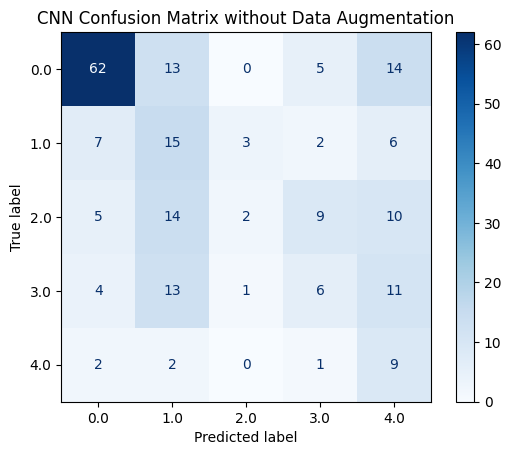

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(truth, preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=np.unique(truth)
)

disp.plot(cmap='Blues')
plt.title("CNN Confusion Matrix without Data Augmentation")
plt.show()

## Post-analysis

In [ ]:
def plot_false_positives_class0(preds, truth, images, num_images_per_class=5, show_reference=True):

    """ Plot false positives where the predicted class is 0."""

    # Ensure inputs are numpy arrays
    preds = np.asarray(preds)
    truth = np.asarray(truth)

    # Masks for false positives and true positives
    fp_mask = (preds == 0) & (truth != 0)
    tp_mask = (preds == 0) & (truth == 0)
    if not np.any(fp_mask):
        print("Aucun faux positif pour la classe 0.")
        return

    # Get unique classes for false positives
    class_labels = np.unique(truth[fp_mask])

    # Determine grid size
    extra_row = 1 if show_reference and np.any(tp_mask) else 0
    n_rows = len(class_labels) + extra_row
    n_cols = num_images_per_class

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
    axs = np.atleast_2d(axs)

    current_row = 0

    # Reference true positives
    if extra_row:
        ref_indices = np.where(tp_mask)[0][:num_images_per_class]

        for col in range(n_cols):
            ax = axs[current_row, col]
            if col < len(ref_indices):
                idx = ref_indices[col]
                ax.imshow(images[idx])
                ax.set_title("Vérité: 0 | Prédit: 0")
                ax.axis("off")
            else:
                ax.axis("off")

        axs[current_row, 0].set_ylabel("Classe 0 ref", rotation=90, fontsize=12)
        current_row += 1

    # Plot false positives for each class
    for cls in class_labels:
        cls_indices = np.where(fp_mask & (truth == cls))[0][:num_images_per_class]

        for col in range(n_cols):
            ax = axs[current_row, col]
            if col < len(cls_indices):
                idx = cls_indices[col]
                ax.imshow(images[idx])
                ax.set_title(f"Vérité: {int(truth[idx])} | Prédit: 0")
                ax.axis("off")
            else:
                ax.axis("off")

        axs[current_row, 0].set_ylabel(f"Classe {int(cls)}", rotation=90, fontsize=12)
        current_row += 1

    # Set overall title and show plot
    fig.suptitle(
        f"Faux positifs (prédit 0) avec référence", fontsize=16
    )
    plt.tight_layout()
    plt.show()

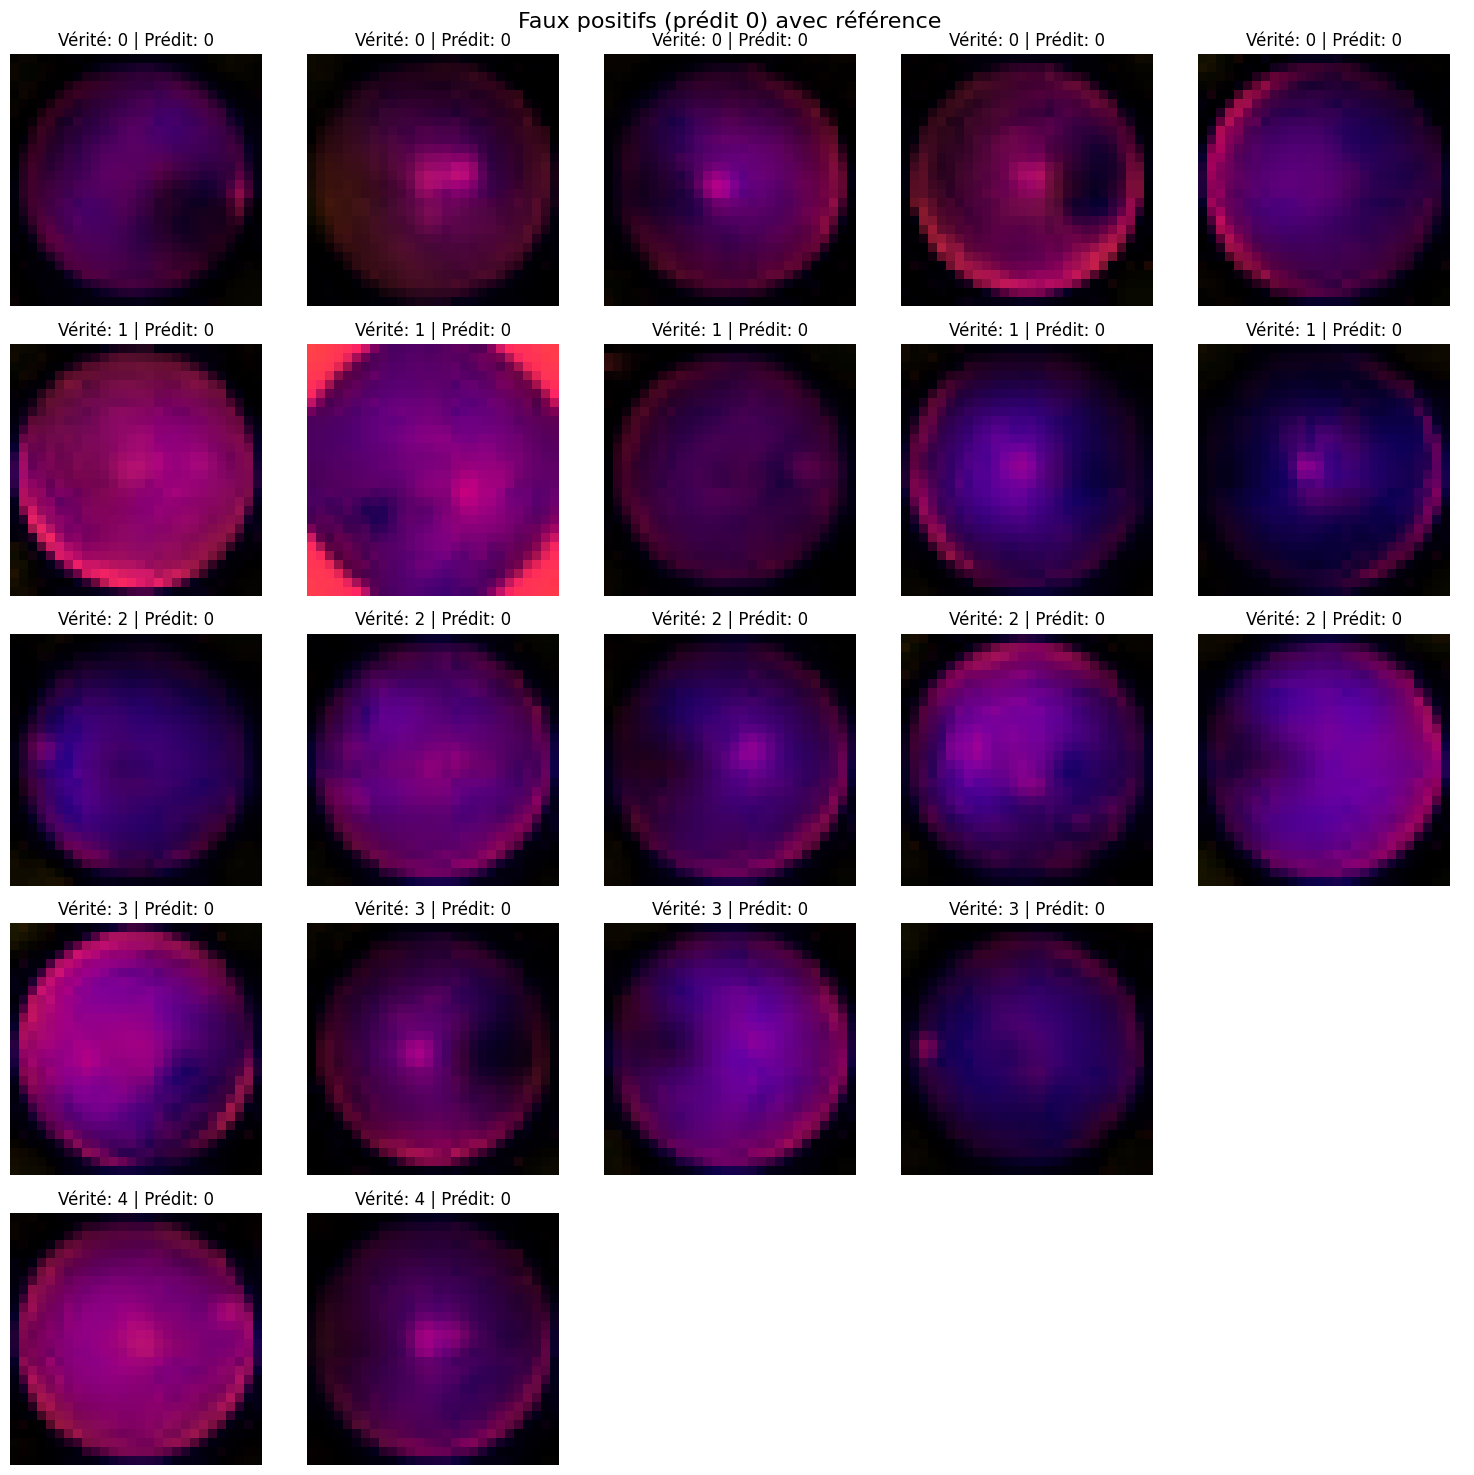

In [60]:
plot_false_positives_class0(preds, truth, images)

# Data Augmentation Version

In [61]:
# Charger le fichier Pickle
train_data_path = Path('data/train_data.pkl')
with open(train_data_path, 'rb') as f:
    data = pickle.load(f)

images = data['images']
labels = data['labels']

On refait la même chose, mais maintenant en enrichissant notre "dataset" original :

In [ ]:
# Normalization constants
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2023, 0.1994, 0.2010)

In [ ]:
# Data augmentation pipeline
train_transforms = transforms_v2.Compose([
    transforms_v2.RandomHorizontalFlip(p=0.5),
    transforms_v2.RandomRotation(15),
    transforms_v2.RandomCrop(28, padding=4),
    transforms_v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms_v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms_v2.ToTensor(),
    transforms_v2.Normalize(MEAN, STD)
])

/opt/anaconda3/envs/kaggle_2/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [64]:
classes = np.unique(labels)
classes

array([0, 1, 2, 3, 4], dtype=uint8)

In [ ]:
def unnormalize(tensor):
    """ Convertir un tenseur normalisé en image affichable (RGB) """
    img = tensor.numpy().transpose((1, 2, 0))
    img = STD * img + MEAN
    img = np.clip(img, 0, 1)

    return img

def show_augmented_vs_original(transform, dataset, num_images=8):
    """ Affiche les images originales (haut) et leurs versions augmentées (bas). """

    # Transformer vers des images (PIL)
    pil_images = [Image.fromarray(array, mode='RGB') for array in dataset]

    # Appliquer les augmentations
    augmented_images = [transform(img) for img in pil_images]

    # Préparer la figure
    fig, axs = plt.subplots(2, num_images, figsize=(16, 4))
    fig.suptitle('Images originales (Top) vs. Images augmentées (Bottom)', fontsize=16)

    for i in range(num_images):

        # Afficher l'image originale
        axs[0, i].imshow(pil_images[i])
        axs[0, i].axis('off')
        if i == 0:
            axs[0, i].set_ylabel('Originales', fontsize=12)

        # Afficher l'image augmentée
        img = unnormalize(augmented_images[i])
        axs[1, i].imshow(img)
        axs[1, i].axis('off')
        if i == 0:
            axs[1, i].set_ylabel('Augmentées', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

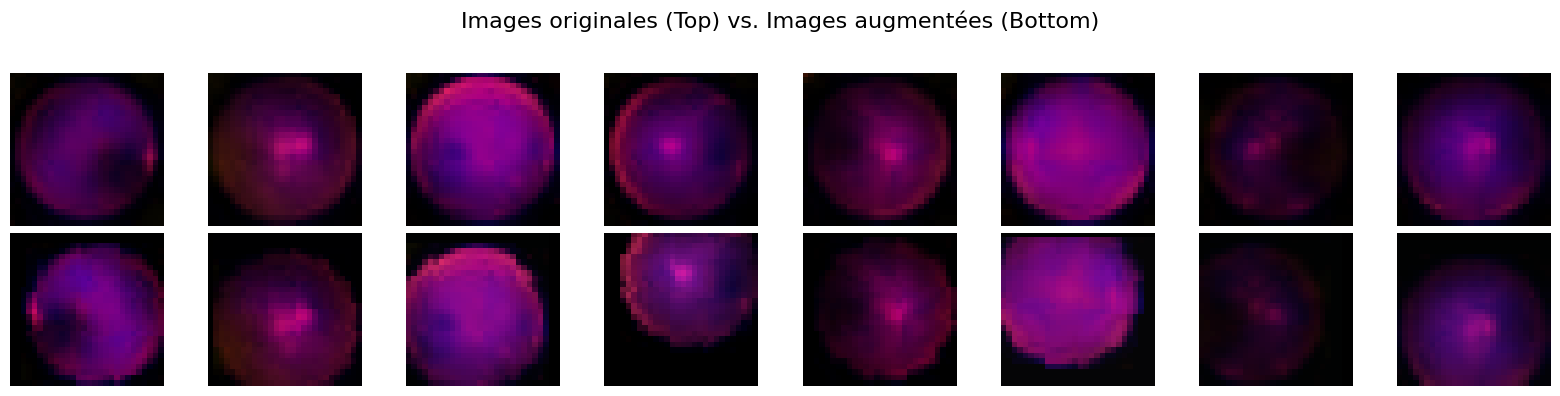

In [66]:
show_augmented_vs_original(transform=train_transforms, dataset=images)

In [ ]:
# Data augmentation presets
AUGMENTATION_PRESETS = [
    # Rotation, cropping, and flipping
    transforms_v2.RandomRotation(degrees=8),
    transforms_v2.RandomCrop(28, padding=3),
    transforms_v2.RandomHorizontalFlip(p=0.5),
    
    # Affine transformations
    transforms_v2.RandomAffine(degrees=0, shear=10, translate=(0.08, 0.08), scale=(0.95, 1.05)),

    # Color and contrast adjustments
    transforms_v2.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.15),
    transforms_v2.RandomAutocontrast(p=0.5),
    transforms_v2.RandomAdjustSharpness(sharpness_factor=1.4, p=0.3),
    transforms_v2.RandomEqualize(p=0.3),

    # Erasing
    transforms_v2.RandomErasing(p=0.25, scale=(0.01, 0.05), ratio=(0.3, 3.3))
]

In [ ]:
def augment_dataset(images, labels, n_augmentations=5):

    """ 
        Augmente le dataset en appliquant des transformations aléatoires. 
        Pour chaque image, crée (n_augmentations - 1) versions augmentées en plus de l'originale.
    """

    print(f"Dataset original : {len(images)} images")
    
    augmented_images = []
    augmented_labels = []
    
    for idx, (img, label) in enumerate(zip(images, labels)):

        # 1) Ajouter l'image originale
        augmented_images.append(img)
        augmented_labels.append(label)
        
        # Créer les versions augmentées
        pil_img = Image.fromarray(img, mode='RGB')
        
        # 2) Générer des augmentations
        for _ in range(n_augmentations - 1):

            # Nombre de transformations
            num_tr = len(AUGMENTATION_PRESETS) // 2

            # Génération selon la liste
            transforms = random.sample(AUGMENTATION_PRESETS, num_tr)
            tr_to_apply = transforms_v2.Compose(transforms)

            # Appliquer les transformations
            aug_img = tr_to_apply(pil_img)
            aug_img_np = np.array(aug_img)
            
            augmented_images.append(aug_img_np)
            augmented_labels.append(label)
        
        # Afficher la progression tous les 100 images
        if (idx + 1) % 100 == 0:
            print(f'Progression : {idx + 1}/{len(images)} images traitées')
    
    # 3) Convertir en arrays numpy
    au_images = np.array(augmented_images)
    au_labels = np.array(augmented_labels)
    
    print(f'Dataset augmenté : {len(au_images)} images')
    print(f'Facteur de multiplication : x{len(au_images) / len(images):.1f}')
    
    return au_images, au_labels

## Training with Data Augmentation

In [ ]:
# Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    images, 
    labels.flatten(), 
    test_size=0.2, 
    random_state=42
)

In [ ]:
# Apply data augmentation to the training set
X_train, y_train = augment_dataset(X_train, y_train, n_augmentations=10)

Dataset original : 864 images
Progression : 100/864 images traitées
Progression : 200/864 images traitées
Progression : 300/864 images traitées
Progression : 400/864 images traitées
Progression : 500/864 images traitées
Progression : 600/864 images traitées
Progression : 700/864 images traitées
Progression : 800/864 images traitées
Dataset augmenté : 8640 images
Facteur de multiplication : x10.0


In [ ]:
# Convert images to tensors and normalize
X_train = torch.tensor(X_train, dtype=torch.float32) / 255.0
X_valid = torch.tensor(X_valid, dtype=torch.float32) / 255.0

# Rearrange dimensions to (N, C, H, W)
X_train = X_train.permute(0, 3, 1, 2)
X_valid = X_valid.permute(0, 3, 1, 2)

# Convert labels to tensors
y_train = torch.tensor(y_train, dtype=torch.long)
y_valid = torch.tensor(y_valid, dtype=torch.long)

# Build TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)

# Mark datasets
train_dataset.train = True
valid_dataset.train = False

# Build DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)

In [72]:
model.num_epochs = 12
model.criterion = nn.CrossEntropyLoss()
model.optimizer = optim.SGD(model.parameters(), lr=0.001)

In [73]:
history_with_data_aug = model.train_model(train_loader)

 ===== Epoch [1/12] done ===== 
 ===== Epoch [2/12] done ===== 
 ===== Epoch [3/12] done ===== 
 ===== Epoch [4/12] done ===== 
 ===== Epoch [5/12] done ===== 
 ===== Epoch [6/12] done ===== 
 ===== Epoch [7/12] done ===== 
 ===== Epoch [8/12] done ===== 
 ===== Epoch [9/12] done ===== 
 ===== Epoch [10/12] done ===== 
 ===== Epoch [11/12] done ===== 
 ===== Epoch [12/12] done ===== 


In [ ]:
# Check accuracy on training data
_, _ = check_accuracy(train_loader, model)

Checking accuracy on training data
Got 4493/8640 with accuracy 52.00%


In [ ]:
# Check accuracy on validation data
preds, truth = check_accuracy(val_loader, model)

Checking accuracy on validation data
Got 108/216 with accuracy 50.00%


## Metrics

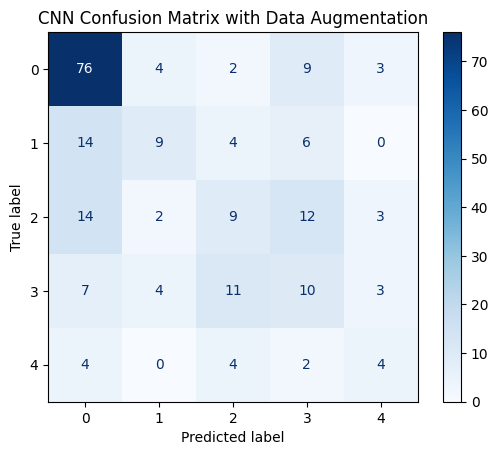

In [ ]:
# Compute and plot confusion matrix
cm = confusion_matrix(truth, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(truth))

disp.plot(cmap='Blues')
plt.title("CNN Confusion Matrix with Data Augmentation")
plt.show()

## Graphs

In [ ]:
def plot_loss_and_accuracy(h1, h2, num_epochs):
    """ Plot training loss and accuracy for models with and without data augmentation. """

    epochs = np.arange(num_epochs)
    
    # Extract loss and accuracy
    h1_loss, h2_loss = h1['loss'], h2['loss']
    h1_accuracy, h2_accuracy = [1 - tensor.cpu() for tensor in h1['error']], [1 - tensor.cpu() for tensor in h2['error']]

    _, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Plot loss
    ax1.plot(epochs, h1_loss, color='blue', label='w/o data aug.')
    ax1.plot(epochs, h2_loss, color='red', label='with data aug.')
    ax1.set_title('Training Loss (Cross Entropy)')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(epochs, h1_accuracy, color='blue', label='w/o data aug.')
    ax2.plot(epochs, h2_accuracy, color='red', label='with data aug.')
    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()

    plt.show()

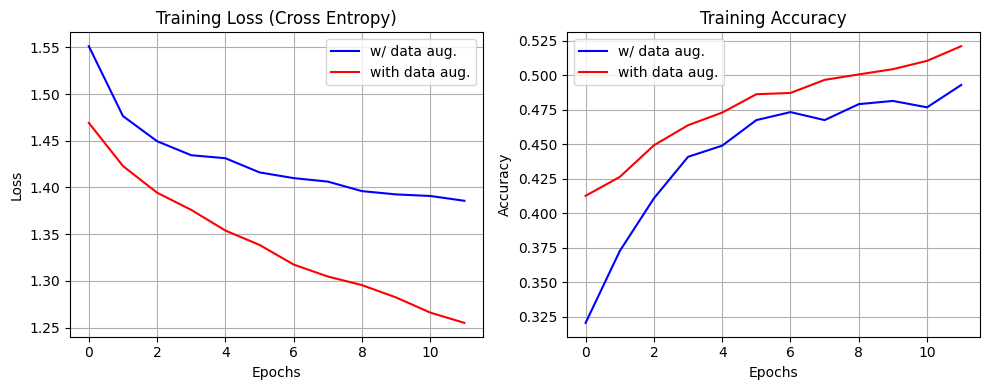

In [103]:
plot_loss_and_accuracy(history_without_data_aug, history_with_data_aug, model.num_epochs)

# Test Set

In [ ]:
# Charger les fichiers Pickle
with open(train_data_path, 'rb') as f:
    train_data = pickle.load(f)

test_data_path = Path('data/test_data.pkl')
with open(test_data_path, 'rb') as f:
    test_data = pickle.load(f)

# Extraire les images et labels
train_images = train_data['images']
train_labels = train_data['labels']
test_images = test_data['images']

In [ ]:
# Vérifier les dimensions des images de test
test_images.shape

(400, 28, 28, 3)

Ré-entraîner le modèle avec l'ensemble d'entraînement + l'ensemble de valdidation :

In [ ]:
# Appliquer l'augmentation de données au dataset d'entraînement
X_train, y_train = augment_dataset(train_images, train_labels.flatten(), n_augmentations=10)

Dataset original : 1080 images
Progression : 100/1080 images traitées
Progression : 200/1080 images traitées
Progression : 300/1080 images traitées
Progression : 400/1080 images traitées
Progression : 500/1080 images traitées
Progression : 600/1080 images traitées
Progression : 700/1080 images traitées
Progression : 800/1080 images traitées
Progression : 900/1080 images traitées
Progression : 1000/1080 images traitées
Dataset augmenté : 10800 images
Facteur de multiplication : x10.0


In [ ]:
# Convertir les images en tenseurs et normaliser
X_train = torch.tensor(X_train, dtype=torch.float32) / 255.0
X_test = torch.tensor(test_images, dtype=torch.float32) / 255.0

# Rearranger les dimensions en (N, C, H, W)
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

# Convertir les labels en tenseurs
y_train = torch.tensor(y_train, dtype=torch.float32)

In [ ]:
# Créer les datasets 
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test)

# Construire les DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Entraîner le modèle
_ = model.train_model(train_loader)

NameError: name 'model' is not defined

In [ ]:
# Obtenir les prédictions sur les données de test
preds = model.get_predictions(test_loader)
preds.shape

torch.Size([400])

In [ ]:
# Convertir les prédictions en CPU pour affichage
preds = preds.cpu()
preds

tensor([0, 1, 0, 1, 0, 0, 4, 2, 0, 3, 1, 3, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0,
        0, 0, 0, 3, 0, 3, 0, 2, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 3, 3, 0, 3,
        0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 1, 4, 0, 0,
        0, 0, 3, 0, 0, 3, 0, 0, 1, 0, 0, 0, 3, 3, 0, 3, 3, 0, 1, 3, 0, 3, 1, 1,
        4, 1, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 3, 1, 0, 1, 0, 0, 0, 0, 3, 0,
        1, 3, 0, 0, 0, 3, 3, 3, 2, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0,
        1, 0, 1, 2, 0, 0, 3, 0, 2, 0, 3, 2, 1, 0, 3, 0, 0, 0, 0, 3, 2, 3, 2, 2,
        0, 0, 2, 0, 2, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 3, 1, 3, 3, 3,
        0, 0, 0, 1, 2, 3, 0, 0, 1, 0, 1, 0, 0, 2, 1, 2, 3, 1, 0, 3, 3, 0, 0, 0,
        0, 3, 2, 3, 0, 1, 3, 2, 2, 3, 3, 0, 3, 0, 0, 2, 0, 0, 0, 1, 3, 3, 0, 3,
        0, 1, 0, 0, 0, 1, 0, 3, 1, 3, 1, 0, 3, 1, 0, 0, 2, 0, 0, 3, 3, 3, 2, 1,
        1, 0, 0, 0, 0, 0, 2, 3, 3, 3, 0, 0, 2, 1, 0, 3, 1, 3, 3, 2, 0, 3, 1, 1,
        4, 3, 0, 1, 1, 1, 0, 2, 0, 3, 0,

In [ ]:
# Generate timestamped submission filename
model_name = 'CNN'
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"submission_{model_name}_{timestamp}.csv"

In [ ]:
# Ensure output directory exists
path = 'output/'
if not os.path.isdir(path): os.mkdir(path)
fn_path = Path(os.path.join(path, filename))

In [ ]:
# Create submission DataFrame
data = {
    'ID': np.arange(1, len(preds) + 1),
    'Label': preds
}

output_df = pd.DataFrame(data)
output_df

,ID,Label
0,1,0
1,2,1
2,3,0
3,4,1
4,5,0
...,...,...
395,396,0
396,397,1
397,398,3
398,399,0


In [ ]:
# Save to CSV
output_df.to_csv(fn_path, index=False)